In [10]:
# Import the required libraries and dependencies
import pandas as pd
import hvplot.pandas
import datetime as dt
import holoviews as hv
from prophet import Prophet
from pathlib import Path

%matplotlib inline

In [11]:
# Import
import os
import numpy as np
from alpaca_trade_api.rest import REST, TimeFrame
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from finta import TA
load_dotenv()

True

In [12]:
import alpaca_trade_api as tradeapi


In [13]:
API_KEY = os.getenv("APCA_API_KEY_ID")
API_SECRET = os.getenv("APCA_SECRET_KEY_ID")
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"
api = tradeapi.REST(
    API_KEY,
    API_SECRET,
    api_version = "v2"
)

In [14]:
# Fetch 1Minute historical bars of Bitcoin
#bars = api.get_crypto_bars("BTCUSD", TimeFrame.Hour).df

# Convert bar timestamp to human readable form
#time = datetime.datetime.fromtimestamp(bar.timestamp / 1000000000)
#symbol = bar.symbol
# Filter data by exchange
#bars = bars[bars.exchange == 'CBSE']
#print(bars)

In [22]:
start_date = "2022-10-01"
end_date = "2022-10-03"

# Retrieve daily price data for Dogecoin and Shiba Inu cryptocurrencies for last 160 days
btc = api.get_crypto_bars("BTCUSD", TimeFrame.Hour, start_date, end_date).df
eth = api.get_crypto_bars("ETHUSD", TimeFrame.Hour, start_date, end_date).df
doge = api.get_crypto_bars("DOGEUSD", TimeFrame.Hour, start_date, end_date).df
shib = api.get_crypto_bars("SHIBUSD", TimeFrame.Hour, start_date, end_date).df
# Create column of daily return percentages
btc["BTC_daily_return"] = btc["close"].pct_change()
eth["ETH_daily_return"] = eth["close"].pct_change()
doge["DOGE_daily_return"] = doge["close"].pct_change()
shib["SHIB_daily_return"] = shib["close"].pct_change()

# Create column of cumulative return percentages
btc["BTC_return"] = btc["BTC_daily_return"].add(1).cumprod().sub(1)
eth["ETH_return"] = eth["ETH_daily_return"].add(1).cumprod().sub(1)
doge["DOGE_return"] = doge["DOGE_daily_return"].add(1).cumprod().sub(1)
shib["SHIB_return"] = shib["SHIB_daily_return"].add(1).cumprod().sub(1)


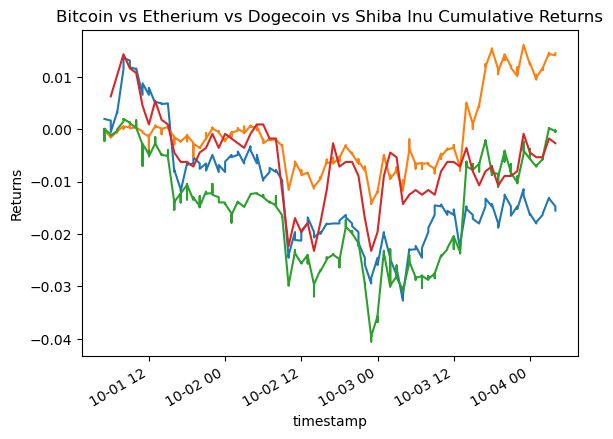

In [23]:
# Visualize Correlation Between Dogecoin and Shiba Inu Historical Returns
ax = doge["DOGE_return"].plot(title="Bitcoin vs Etherium vs Dogecoin vs Shiba Inu Cumulative Returns")
btc["BTC_return"].plot(ax=ax)
eth["ETH_return"].plot(ax=ax)
shib["SHIB_return"].plot(ax=ax)
ax.set_ylabel("Returns")
plt.show()

In [24]:
btc = btc[btc.exchange == 'CBSE']
print(btc)

                          exchange      open      high       low     close  \
timestamp                                                                    
2022-10-01 05:00:00+00:00     CBSE  19408.81  19418.88  19259.01  19322.23   
2022-10-01 06:00:00+00:00     CBSE  19322.24  19326.71  19269.31  19295.00   
2022-10-01 07:00:00+00:00     CBSE  19295.51  19344.75  19260.00  19311.03   
2022-10-01 08:00:00+00:00     CBSE  19310.16  19351.09  19304.41  19334.21   
2022-10-01 09:00:00+00:00     CBSE  19333.69  19367.50  19305.47  19331.75   
...                            ...       ...       ...       ...       ...   
2022-10-04 00:00:00+00:00     CBSE  19632.43  19726.45  19532.56  19565.59   
2022-10-04 01:00:00+00:00     CBSE  19565.55  19584.85  19507.42  19508.47   
2022-10-04 02:00:00+00:00     CBSE  19507.63  19559.44  19495.32  19547.20   
2022-10-04 03:00:00+00:00     CBSE  19546.70  19633.61  19538.89  19604.39   
2022-10-04 04:00:00+00:00     CBSE  19604.39  19646.57  19557.78

In [25]:
# Drop columns that won't be used
df = bars.drop("volume", axis=1)
df

,exchange,open,high,low,close,trade_count,vwap
timestamp,,,,,,,
2022-11-28 06:00:00+00:00,BNCU,16158.08,16207.83,16132.59,16203.79,1869,16165.618250
2022-11-28 06:00:00+00:00,CBSE,16151.74,16209.03,16132.02,16204.54,12304,16165.941556
2022-11-28 06:00:00+00:00,ERSX,16153.80,16204.30,16132.20,16199.30,1023,16166.233086
2022-11-28 07:00:00+00:00,BNCU,16204.12,16208.71,16182.69,16200.18,618,16194.113827
2022-11-28 07:00:00+00:00,CBSE,16203.85,16206.66,16183.41,16200.19,4128,16194.071954
2022-11-28 07:00:00+00:00,ERSX,16200.50,16202.30,16183.40,16200.00,284,16192.232061


In [26]:
#pd.datetime.strptime("timestamp", '%d-%b-%Y %H:%M:%S')

In [27]:
signals_df = df.loc[:, ["close"]].copy()
signals_df

,close
timestamp,
2022-11-28 06:00:00+00:00,16203.79
2022-11-28 06:00:00+00:00,16204.54
2022-11-28 06:00:00+00:00,16199.30
2022-11-28 07:00:00+00:00,16200.18
2022-11-28 07:00:00+00:00,16200.19
2022-11-28 07:00:00+00:00,16200.00


In [28]:
# Make API call
#prices = api.get_bars(ticker, "1Min").df

# Reorganize the DataFrame
#prices = pd.concat([prices], axis=1, keys=["BTC"])

# Get final closing price
#limit_amount = prices["BTC"]["close"][-1]

In [29]:
# Set `bokeh` to render hvPlot charts
#hv.extension("bokeh")

# Use hvPlot to visually inspect the price data
df["close"].hvplot()

:Curve   [timestamp]   (close)

In [30]:
# Reset the index so that we recode the columns for Prophet
df = signals_df.reset_index()
df

,timestamp,close
0,2022-11-28 06:00:00+00:00,16203.79
1,2022-11-28 06:00:00+00:00,16204.54
2,2022-11-28 06:00:00+00:00,16199.30
3,2022-11-28 07:00:00+00:00,16200.18
4,2022-11-28 07:00:00+00:00,16200.19
5,2022-11-28 07:00:00+00:00,16200.00


In [ ]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df =df.rename(columns={"timestamp":"ds", "close":"y"})
df.head()

,ds,y
0,2022-11-28 06:00:00+00:00,16203.79
1,2022-11-28 06:00:00+00:00,16204.54
2,2022-11-28 06:00:00+00:00,16199.30
3,2022-11-28 07:00:00+00:00,16200.18
4,2022-11-28 07:00:00+00:00,16200.19


In [42]:
# dt_tz is a datetime.datetime object
df['ds'] = df['ds'].dt.tz_localize(None)

In [44]:
## Step 4:  View dataframe shape, and the first and last five rows of the  DataFrame

In [45]:
# View dataframe shape, and the first and last five rows of the mercado_prophet_df DataFrame
# YOUR CODE HERE

In [46]:
## Step 5:  Sort the DataFrame by `ds` in ascending order, so as to arrange the data chronologically from past to present. With that done, visually inspect the price data using `hvplot`

In [47]:
# Sort the DataFrame by `ds` in ascending order
df = df.sort_values(by=['ds'], ascending=True)

# Display sample data from head and tail
df

,ds,y
0,2022-11-28 06:00:00,16203.79
1,2022-11-28 06:00:00,16204.54
2,2022-11-28 06:00:00,16199.30
3,2022-11-28 07:00:00,16200.18
4,2022-11-28 07:00:00,16200.19
5,2022-11-28 07:00:00,16200.00


In [48]:
# Set `bokeh` to render hvPlot charts
#hv.extension("bokeh")

# Diplay the data using hvPlot
df.hvplot()

:Curve   [index]   (y)

In [49]:
## Step 6: Call the `Prophet` function, and store it as an object

In [50]:
# Call the Prophet function, store as an object
m = Prophet()
m

In [51]:
# Fit the Prophet model.
m.fit(df)

21:39:56 - cmdstanpy - INFO - Chain [1] start processing
21:39:57 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days)
future_trends = m.make_future_dataframe(periods=1000, freq='H')

# View the last five rows of the predictions
future_trends.tail()

In [ ]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = m.predict(future_trends)

# Display the first five rows of the forecast DataFrame
forecast_trends

In [ ]:
## Step 10: Plot the Prophet predictions for the `forecast_trends` data

In [ ]:
# Plot the Prophet predictions for the Mercado trends data
m.plot(forecast_trends)

In [ ]:
## Step 11: Use the `plot_components` function to visualize the forecast results

In [ ]:
## Step 12: Set the `datetime` index of the `forecast_trends` data, using the `ds` column

In [ ]:
# At this point, it's useful to set the `datetime` index of the forecast data.
forecast_trends = forecast_trends.set_index('ds')# YOUR CODE HERE
forecast_trends.head()

In [ ]:
## Step 13: From the `forecast_trends` DataFrame, use `hvPlot` to visualize the `yhat`, `yhat_lower`, and `yhat_upper` columns over the last 10 days (i.e., the last 240 rows)

* `yhat` represents the most likely (average) forecast.

* `yhat_lower` and `yhat_upper` represents the worst and best case prediction.

    * These are based on what are known as 80% confidence intervals.

In [ ]:
# From the `forecast_trends` DataFrame, use hvPlot to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 10 days (24*10 = 240) 
forecast_trends[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-240:,:].hvplot()

In [ ]:
## Step 14: Create a `forecast_march_2021` Dataframe, which contains just forecasts for that month. The DataFrame should include the columns `yhat_upper`, `yhat_lower`, and `yhat`. Replace the column names to something less technical sounding: `Best Case`, `Worst Case`, and `Most Likely Case`, respectively

In [ ]:
# Create a `forecast_march_2021` Dataframe, which contains just forecasts for that month
# The DataFrame should include the columns yhat_upper, yhat_lower, and yhat
forecast_march_2021 = forecast_trends[['yhat', 'yhat_lower', 'yhat_upper']].loc['2021-03-01':'2021-03-31']

# Replace the column names to something less technical sounding
forecast_march_2021 = forecast_march_2021.rename(columns={"yhat_upper":"Best Case", "yhat":"Most Likely Case", "yhat_lower":"Worst Case"})

forecast_march_2021.head()

In [ ]:
## Step 15: Display the average forecasted price for March 2021

In [ ]:
# Display the average forecasted price for March 2021
march_average = forecast_march_2021.mean()
march_average

In [ ]:
## Matt's Prophet Forecasting  Challenge

In [ ]:
# Extend the existing bitcoin hourly database to the current date
# Upload the bitcoin_hourly.csv file
data_path = ("../Resources/Bitfinex_BTCUSD_1h.csv")
df_new = pd.read_csv(data_path,
                 index_col="date",
                 infer_datetime_format=True,
                 parse_dates=True
                )

# Drop columns that won't be used
df_new = df_new.drop(['unix', 'symbol', 'open', 'high', 'low', 'Volume USD', 'Volume BTC'], axis=1)

# Selecting required period and sorting
df_new = df_new.loc['2021-02-12 06:00:00':'2022-10-20 00:00:00']
df_new = df_new.sort_index()

# Reset the index so that we recode the columns for Prophet
df_new = df_new.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
df_new =df_new.rename(columns={"date":"ds", "close":"y"})

# Preview the dataset
df_new

In [ ]:
df

In [ ]:
# Combine two DataFrames 
df_update = pd.concat([df, df_new], join='outer')
df_update = df_update.reset_index()
df_update = df_update.drop('index', axis=1)
df_update

In [ ]:
#Call the Prophet function
m2 = Prophet()
m2

In [ ]:
# Fit the Prophet model.
m2.fit(df_update)

In [ ]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days)
future_update = m2.make_future_dataframe(periods=1000, freq='H')
future_update.tail()

In [ ]:
trends_update = m2.predict(future_update)
trends_update.tail()

In [ ]:
# Plot the Prophet predictions 
m2.plot(trends_update)

In [ ]:
# Use the plot_components function to visualize the forecast
figures_update = m2.plot_components(trends_update)

In [ ]:
trends_update[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-1000:,:].plot()

In [ ]:
# Analysis
Over the next 40 days according to the predictions of Prophet the market of bitcoin looks bearish. Meaning we are expecting falling prices. 
However it may be a good time to buy for a good long-term investment. :o)